In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydot --quiet
!pip install mlflow --quiet
!pip install dagshub --quiet
!pip install -q transformers==4.37.2
!pip install "pandas<2.0.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.6/226.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata 

In [3]:
import dagshub
import mlflow
dagshub.init("w266-final-project", "bho1", mlflow=True)


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=924dc31f-cd6c-4567-854d-0603d1f08a05&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=9c8a1e4f64336c9405534df5e895418113f0e5431e50a3ca0a7df3248119e083




Initialized MLflow to track repo "bho1/w266-final-project"

Repository bho1/w266-final-project initialized!

In [4]:
# Example
if False:
  mlflow.start_run()

  # train your model...

  mlflow.log_param("parameter name ", "value")
  mlflow.log_metric("metric name", 1)

  mlflow.end_run()

In [5]:
import os
import pickle
import itertools


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model


In [6]:
from transformers import RobertaTokenizer, TFRobertaModel

from transformers import logging
logging.set_verbosity_error()

In [7]:
# brendanho123
data_path = 'drive/My Drive/Colab Notebooks/W266/Final Project/data'

# bho1
# data_path = 'drive/My Drive/Colab Notebooks/Final Project/data'

# bholly597
# data_path = 'drive/My Drive/Final Project/data'

# cwgiant
# data_path = '/content/drive/MyDrive/Final Project/data'

In [8]:
checkpoint = 'roberta-base'
bert_tokenizer = RobertaTokenizer.from_pretrained(checkpoint)
bert_model = TFRobertaModel.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [9]:
unpickled_data = {}

keys_to_unpickle = [
    'train_data',
    'test_data',
    'val_data',
]


for key in keys_to_unpickle:
    filename = f'{data_path}/cleaned_data/{key}.pkl'
    with open(filename, 'rb') as file:
        unpickled_data[key] = pickle.load(file)


train_data = unpickled_data['train_data']
test_data = unpickled_data['test_data']
val_data = unpickled_data['val_data']


In [10]:
MAX_SEQUENCE_LENGTH = 128               # set max_length of the input sequence

# num_train_examples = 2000
# num_val_examples = 200



num_train_examples = 10000
num_val_examples = 1000


# num_train_examples = 50000
# num_val_examples = 5000

# num_train_examples = train_data.shape[0]
# num_val_examples = test_data.shape[0]


In [11]:
x_train_file_path = f'{data_path}/tokens/x_RoBERTa_train_tokens_{num_train_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
x_val_file_path = f'{data_path}/tokens/x_RoBERTa_val_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
x_test_file_path = f'{data_path}/tokens/x_RoBERTa_test_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'

# Get train data
if os.path.exists(x_train_file_path):
  x_train = pickle.load(open(x_train_file_path, 'rb'))
else:
  x_train = bert_tokenizer(list(train_data['text'])[:num_train_examples],
                   add_special_tokens=True,
                   max_length=MAX_SEQUENCE_LENGTH,
                   padding='max_length',
                   return_token_type_ids=True,
                   truncation=True,
                   return_tensors="tf")

  with open(x_train_file_path, 'wb') as f:
    pickle.dump(x_train, f)

# Get val data
if os.path.exists(x_val_file_path):
  x_val = pickle.load(open(x_val_file_path, 'rb'))
else:
  x_val = bert_tokenizer(list(val_data['text'])[:num_val_examples],
              add_special_tokens=True,
                   max_length=MAX_SEQUENCE_LENGTH,
                   padding='max_length',
                   return_token_type_ids=True,
                   truncation=True,
                   return_tensors="tf")

  with open(x_val_file_path, 'wb') as f:
    pickle.dump(x_val, f)

# Get test data
if os.path.exists(x_test_file_path):
  x_test = pickle.load(open(x_test_file_path, 'rb'))
else:
  x_test = bert_tokenizer(list(test_data['text'])[:num_val_examples],
                add_special_tokens=True,
                   max_length=MAX_SEQUENCE_LENGTH,
                   padding='max_length',
                   return_token_type_ids=True,
                   truncation=True,
                   return_tensors="tf")

  with open(x_test_file_path, 'wb') as f:
    pickle.dump(x_test, f)


y_train = train_data['Overall_score'][:num_train_examples]
y_val = val_data['Overall_score'][:num_val_examples]
y_test = test_data['Overall_score'][:num_val_examples]


In [12]:
train_synopsis_file_path = f'{data_path}/tokens/RoBERTa_train_synopsis_tokens_{num_train_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
val_synopsis_file_path = f'{data_path}/tokens/RoBERTa_val_synopsis_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
test_synopsis_file_path = f'{data_path}/tokens/RoBERTa_test_synopsis_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'

if os.path.exists(train_synopsis_file_path):
  bert_train_synopsis = pickle.load(open(train_synopsis_file_path, 'rb'))
else:
  train_synopsis = train_data['synopsis'].astype(str).tolist()
  bert_train_synopsis = bert_tokenizer(train_synopsis[:num_train_examples],
                add_special_tokens=True,
                   max_length=MAX_SEQUENCE_LENGTH,
                   padding='max_length',
                   return_token_type_ids=True,
                   truncation=True,
                   return_tensors="tf")
  with open(train_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_train_synopsis, f)

if os.path.exists(val_synopsis_file_path):
  bert_val_synopsis = pickle.load(open(val_synopsis_file_path, 'rb'))
else:
  val_synopsis = test_data['synopsis'].astype(str).tolist()
  bert_val_synopsis = bert_tokenizer(val_synopsis[:num_val_examples],
                add_special_tokens=True,
                   max_length=MAX_SEQUENCE_LENGTH,
                   padding='max_length',
                   return_token_type_ids=True,
                   truncation=True,
                   return_tensors="tf")
  with open(val_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_val_synopsis, f)

if os.path.exists(test_synopsis_file_path):
  bert_test_synopsis = pickle.load(open(test_synopsis_file_path, 'rb'))
else:
  test_synopsis = test_data['synopsis'].astype(str).tolist()
  bert_test_synopsis = bert_tokenizer(test_synopsis[:num_val_examples],
                add_special_tokens=True,
                   max_length=MAX_SEQUENCE_LENGTH,
                   padding='max_length',
                   return_token_type_ids=True,
                   truncation=True,
                   return_tensors="tf")
  with open(test_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_test_synopsis, f)

### Model

In [13]:
def create_two_tower_model(
    bert_model,
    train_layers=True,
    layers=[70, 50, 20, 10],
    dropout=0.3,
    optimizer_type='adam',
    learning_rate=0.00005,
    loss='mean_absolute_error',
):

    if not train_layers:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    else:
        # Train all layers of the BERT model
        bert_model.trainable = True

    # Anime Embeddings
    anime_input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_input_ids_layer')
    anime_token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_token_type_ids_layer')
    anime_attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='anime_attention_mask_layer')

    bert_anime_inputs = {
        'input_ids': anime_input_ids,
        'token_type_ids': anime_token_type_ids,
        'attention_mask': anime_attention_mask
    }

    bert_anime_out = bert_model(bert_anime_inputs)

    # pooler_anime_token = bert_anime_out[1]
    cls_anime_token = bert_anime_out[0][:, 0, :]

    # anime_flatten = layers.Flatten(name='flatten_anime')(cls_anime_token)
    anime_model = keras.Model(inputs=[anime_input_ids, anime_token_type_ids, anime_attention_mask], outputs=cls_anime_token)


    # User Embeddings
    user_input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_input_ids_layer')
    user_token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_token_type_ids_layer')
    user_attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='user_attention_mask_layer')

    bert_user_inputs = {
        'input_ids': user_input_ids,
        'token_type_ids': user_token_type_ids,
        'attention_mask': user_attention_mask
    }

    bert_user_out = bert_model(bert_user_inputs)

    # pooler_user_token = bert_user_out[1]
    cls_user_token = bert_user_out[0][:, 0, :]
    # user_flatten = layers.Flatten(name='flatten_user')(cls_user_token)
    user_model = keras.Model(inputs=[user_input_ids, user_token_type_ids, user_attention_mask], outputs=cls_user_token)

    # Two Tower Model
    cls_anime_token_reshaped = tf.expand_dims(cls_anime_token, axis=1)
    cls_user_token_reshaped = tf.expand_dims(cls_user_token, axis=2)


    merged =  tf.matmul(cls_anime_token_reshaped, cls_user_token_reshaped)



    dense_layers = []
    dropout_layers = []
    for i, num_layers in enumerate(layers):
      if i == 0:
        dense = tf.keras.layers.Dense(num_layers, name=f'dense_{i + 1}', activation='relu')(merged)
      else:
        dense = tf.keras.layers.Dense(num_layers, name=f'dense_{i + 1}', activation='relu')(dropout_layers[-1])
      dense_layers.append(dense)

      if i != len(layers) - 1:
        dropout_layer = tf.keras.layers.Dropout(dropout, name=f'dropout_{i + 1}')(dense_layers[-1])
        dropout_layers.append(dropout_layer)

    result = tf.keras.layers.Dense(1, name='result', activation="relu") (dense_layers[-1])

    if optimizer_type == 'adam':
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_type == 'adagrad':
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_type == 'adamax':
      optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    model = keras.Model(inputs=[anime_input_ids, anime_token_type_ids, anime_attention_mask, user_input_ids, user_token_type_ids, user_attention_mask], outputs=result)
    model.compile(optimizer=optimizer, loss=loss)

    return model, anime_model, user_model

### Parameters

In [14]:
param_grid = {
    'train_layers': [True],
    'layers': [[70, 50, 20, 10]],
    'dropout': [0.5],
    'optimizer_type': ['adam'],
    'learning_rate': [0.005], #0.00005,0.0005,
    'loss': ['mean_absolute_error'],#, 'mean_squared_error'],
}

In [15]:
param_combinations = list(itertools.product(*param_grid.values()))
param_list = [{param_name: params for param_name, params in zip(param_grid.keys(), parameters)} for parameters in param_combinations]
print(f'Number of hyperparameter combinations: {len(param_list)}')
print(param_list[0])

Number of hyperparameter combinations: 1
{'train_layers': True, 'layers': [70, 50, 20, 10], 'dropout': 0.5, 'optimizer_type': 'adam', 'learning_rate': 0.005, 'loss': 'mean_absolute_error'}


In [16]:
# param_list.index({'train_layers': True, 'layers': [70, 50, 20, 10], 'dropout': 0.5, 'optimizer_type': 'adamax', 'learning_rate': 0.005, 'loss': 'mean_absolute_error'})

In [17]:
# # Default parameters
# parameters = {
#     'train_layers': True,
#     'layers': [70, 50, 20, 10],
#     'dropout': 0.5,
#     'optimizer_type': 'adam',
#     'learning_rate': 0.00005,
#     'loss': 'mean_absolute_error',
# }

In [18]:
# bert_model = TFBertModel.from_pretrained(checkpoint)
# two_tower_bert_model, anime_model, user_model = create_two_tower_model(bert_model, **parameters)

In [19]:
# two_tower_bert_model.summary()

In [20]:
# keras.utils.plot_model(two_tower_bert_model, show_shapes=True, dpi=90)

In [21]:
track_metrics = False

In [22]:
batch_size = 16
epochs = 20

callback  = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)


for parameters in param_list:
    print(parameters)
    bert_model = TFRobertaModel.from_pretrained(checkpoint)
    two_tower_bert_model, anime_model, user_model = create_two_tower_model(bert_model, **parameters)

    if track_metrics:
      mlflow.start_run()
      mlflow.set_tag("model", "two_tower_roberta_review-score_model")

    two_tower_bert_model_history = two_tower_bert_model.fit(
        [
            bert_train_synopsis.input_ids,
            bert_train_synopsis.token_type_ids,
            bert_train_synopsis.attention_mask,
            x_train.input_ids,
            x_train.token_type_ids,
            x_train.attention_mask
        ],
        y_train,
        validation_data=(
            [
                bert_val_synopsis.input_ids,
                bert_val_synopsis.token_type_ids,
                bert_val_synopsis.attention_mask,
                x_val.input_ids,
                x_val.token_type_ids,
                x_val.attention_mask
            ], y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[callback],
    )
    if track_metrics:
      for key, value in parameters.items():
          mlflow.log_param(key, value)


      mlflow.log_param('train_size', num_train_examples)
      mlflow.log_param('val_size', num_val_examples)
      mlflow.log_param('batch_size', batch_size)
      mlflow.log_param('epochs', epochs)
      mlflow.log_param('max_sequence_length', MAX_SEQUENCE_LENGTH)
      mlflow.log_param('run_location', 'colab')

      mlflow.log_metric('epochs_ran', len(two_tower_bert_model_history.history['val_loss']))
      mlflow.log_metric("start train_loss", two_tower_bert_model_history.history['loss'][0])
      mlflow.log_metric("end train_loss", two_tower_bert_model_history.history['loss'][-1])
      mlflow.log_metric("start val_loss", two_tower_bert_model_history.history['val_loss'][0])
      mlflow.log_metric("end val_loss", two_tower_bert_model_history.history['val_loss'][-1])

      mlflow.end_run()



{'train_layers': True, 'layers': [70, 50, 20, 10], 'dropout': 0.5, 'optimizer_type': 'adam', 'learning_rate': 0.005, 'loss': 'mean_absolute_error'}
Epoch 1/20


625/625 [==============================] - 259s 319ms/step - loss: 2.9219 - val_loss: 1.8610
Epoch 2/20
625/625 [==============================] - 182s 291ms/step - loss: 1.8106 - val_loss: 1.7683
Epoch 3/20
625/625 [==============================] - 184s 295ms/step - loss: 1.7885 - val_loss: 1.7534
Epoch 4/20
625/625 [==============================] - 181s 289ms/step - loss: 1.7833 - val_loss: 1.7523
Epoch 5/20
625/625 [==============================] - 180s 288ms/step - loss: 1.7847 - val_loss: 1.7573
Epoch 6/20
625/625 [==============================] - 180s 288ms/step - loss: 1.7829 - val_loss: 1.7525
Epoch 7/20
625/625 [==============================] - 180s 288ms/step - loss: 1.7796 - val_loss: 1.7697
Epoch 8/20
625/625 [==============================] - 176s 281ms/step - loss: 1.7818 - val_loss: 1.7890
Epoch 9/20
625/625 [==============================] - 179s 287ms/step - loss: 1.7806 - val_loss: 1.7597
Epoch 10/20
625/625 [==============================] - 180s 287ms/step - lo

In [ ]:
# two_tower_roberta_model_history.summary()

In [ ]:
# two_tower_roberta_model_history.history['precision_at_k']

In [ ]:
mlflow.end_run()

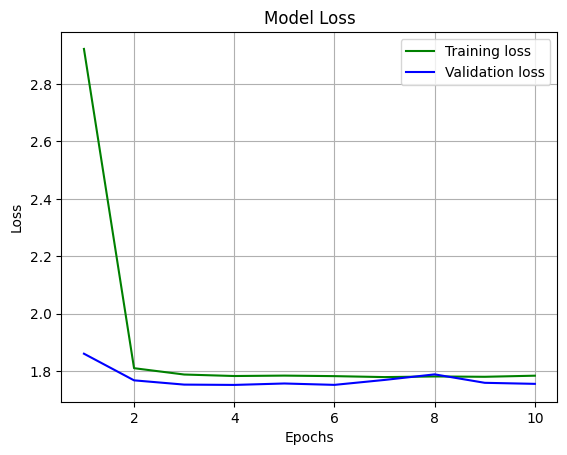

In [23]:
train_loss = two_tower_bert_model_history.history['loss']
val_loss = two_tower_bert_model_history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Embeddings

In [24]:
import pandas as pd
all_data = pd.concat([train_data[:num_train_examples], val_data[:num_val_examples], test_data[:num_val_examples]])
animes = pd.read_csv(f'{data_path}/raw_data/animes_final.csv')

In [25]:
all_anime_ids = all_data['anime_uid'].unique()
all_present_anime_ids = animes[animes['uid'].isin(all_anime_ids)].sort_values(by='popularity')['uid']
all_present_anime_ids

740       1535
7876     11757
3         5114
16       30276
140      22319
         ...  
12503    36619
8579     38043
10528    36352
12335    39215
9454     39560
Name: uid, Length: 3278, dtype: int64

In [26]:

unique_anime_ids = all_present_anime_ids[:2000]

anime_id_dict = {id: i for i, id in enumerate(unique_anime_ids)}

print(f'The length of the unique anime ids is {len(unique_anime_ids)}')

The length of the unique anime ids is 2000


In [27]:
anime_recommendation_input_ids = []
anime_recommendation_token_type_ids = []
anime_recommendation_attention_mask = []
for anime_id in unique_anime_ids:
    try:
      temp_df = train_data.iloc[:num_train_examples].reset_index()
      anime_idx = temp_df.loc[temp_df['anime_uid'] == anime_id].index[0]
      anime_recommendation_input_ids.append(bert_train_synopsis.input_ids[anime_idx])
      anime_recommendation_token_type_ids.append(bert_train_synopsis.token_type_ids[anime_idx])
      anime_recommendation_attention_mask.append(bert_train_synopsis.attention_mask[anime_idx])
    except IndexError:
      try:
        temp_df = val_data.iloc[:num_val_examples].reset_index()
        anime_idx = temp_df.loc[temp_df[:num_val_examples]['anime_uid'] == anime_id].index[0]
        anime_recommendation_input_ids.append(bert_val_synopsis.input_ids[anime_idx])
        anime_recommendation_token_type_ids.append(bert_val_synopsis.token_type_ids[anime_idx])
        anime_recommendation_attention_mask.append(bert_val_synopsis.attention_mask[anime_idx])
      except IndexError:
        try:
          temp_df = test_data.iloc[:num_val_examples].reset_index()
          anime_idx = temp_df.loc[temp_df[:num_val_examples]['anime_uid'] == anime_id].index[0]
          anime_recommendation_input_ids.append(bert_test_synopsis.input_ids[anime_idx])
          anime_recommendation_token_type_ids.append(bert_test_synopsis.token_type_ids[anime_idx])
          anime_recommendation_attention_mask.append(bert_test_synopsis.attention_mask[anime_idx])
        except IndexError:
          print(f'Could not find index for {anime_id}')



In [ ]:
print(len(anime_recommendation_input_ids))
print(len(anime_recommendation_token_type_ids))
print(len(anime_recommendation_attention_mask))


2000
2000
2000


In [28]:
input_dataset = tf.data.Dataset.zip(((
    tf.data.Dataset.from_tensor_slices(anime_recommendation_input_ids),
    tf.data.Dataset.from_tensor_slices(anime_recommendation_token_type_ids),
    tf.data.Dataset.from_tensor_slices(anime_recommendation_attention_mask),
),)).batch(len(anime_recommendation_attention_mask))

In [29]:
anime_embeddings = anime_model.predict(input_dataset)

1/1 [==============================] - 8s 8s/step


In [ ]:
anime_embeddings[0][:10]

array([-0.05497241,  0.14721712, -0.17721307, -0.00849655, -0.06847119,
       -0.02836371,  0.07166308,  0.01663498, -0.01384283, -0.04095878],
      dtype=float32)

In [ ]:
anime_embeddings[5][:10]

array([-0.05497235,  0.14721711, -0.17721307, -0.00849656, -0.06847118,
       -0.02836371,  0.07166308,  0.01663496, -0.01384283, -0.04095879],
      dtype=float32)

In [ ]:
def tsne_plot(
    embeddings,
    embedding_labels,
    limit = len(unique_anime_ids),
    figsize=(15, 15)
):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(embeddings[:limit])

    # Store x and y values from T-SNE
    x, y = [], []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize)
    # Plot x,y values
    for i, label in enumerate(embedding_labels[:limit]):
        plt.scatter(x[i],y[i])
        plt.annotate(i, xy=(x[i], y[i]), ha='right', va='bottom', xytext=(3, 2), textcoords='offset points', )

    plt.show()
    return new_values

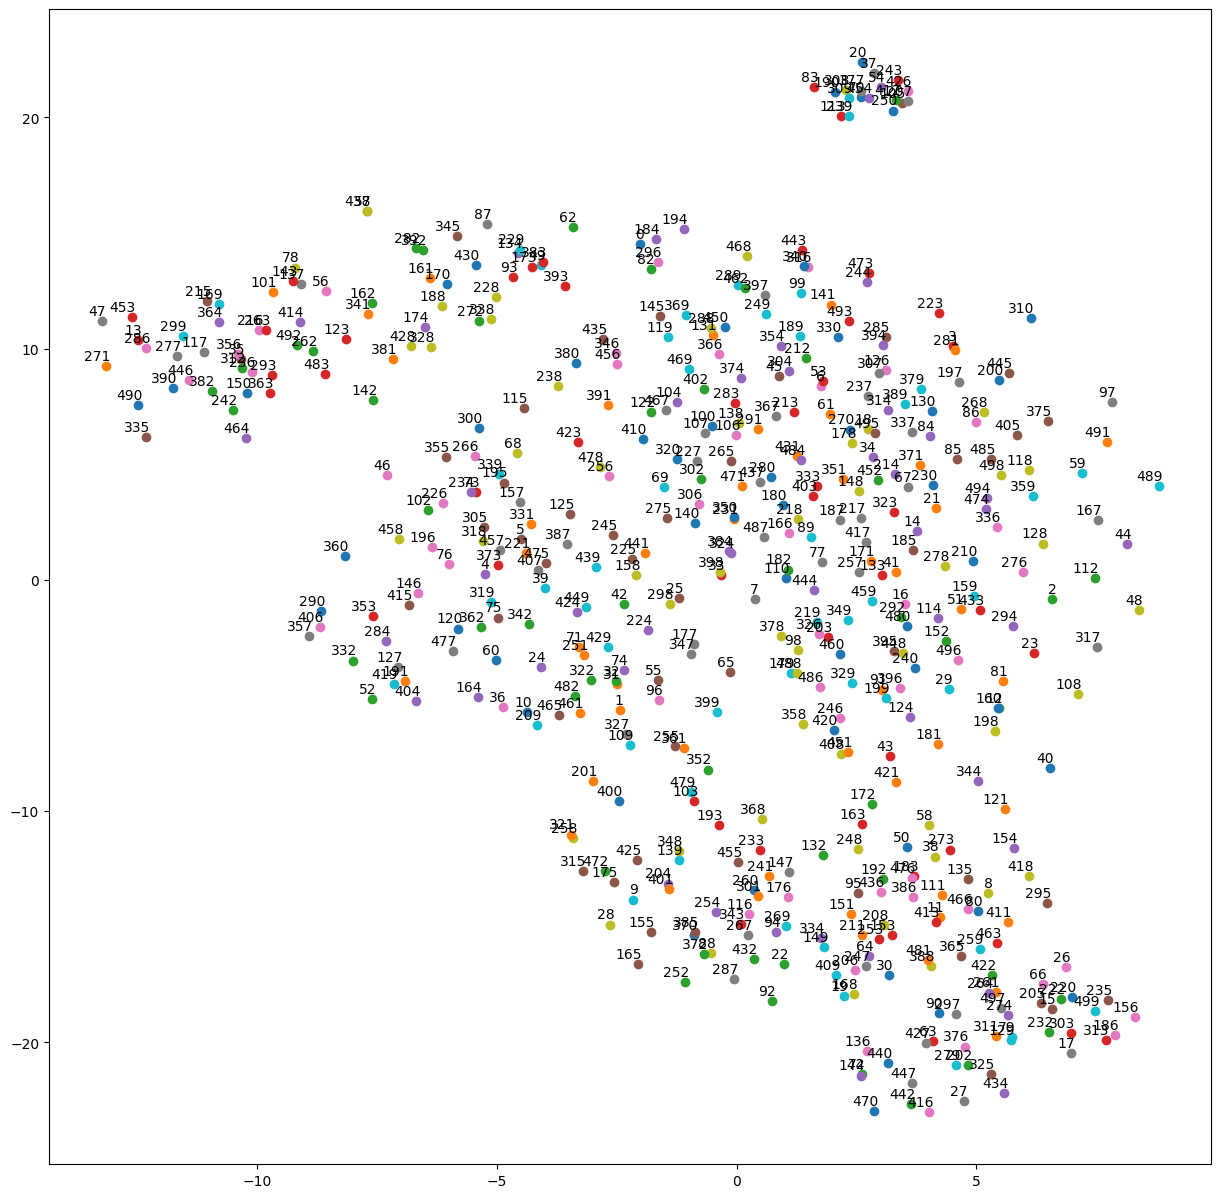

In [ ]:
pca_values = tsne_plot(anime_embeddings, unique_anime_ids, 500)

### KNN

In [30]:
n_neighbors = 10

In [31]:
# Fit a KNN Clasiffier

clf = KNeighborsClassifier(n_neighbors=n_neighbors+1)
clf.fit(anime_embeddings, unique_anime_ids)

KNeighborsClassifier(n_neighbors=11)

In [32]:
def anime_recommendations(user_embedding, n_neibhors=n_neighbors):
    _, idxs = clf.kneighbors(user_embedding.reshape(1, -1),  n_neighbors=n_neighbors)
    idxs = idxs.reshape(10,1)

    df_indices = pd.DataFrame(idxs, columns = ['anime_uid'])

    return df_indices.merge(animes.rename(columns={'uid': 'anime_uid'}), on='anime_uid', how='inner')['title']

In [33]:
user_input_dataset = tf.data.Dataset.zip(((
    tf.data.Dataset.from_tensor_slices(x_test.input_ids),
    tf.data.Dataset.from_tensor_slices(x_test.token_type_ids),
    tf.data.Dataset.from_tensor_slices(x_test.attention_mask),
),)).batch(len(x_test.attention_mask))

In [34]:
user_embeddings = user_model.predict(user_input_dataset)

1/1 [==============================] - 6s 6s/step


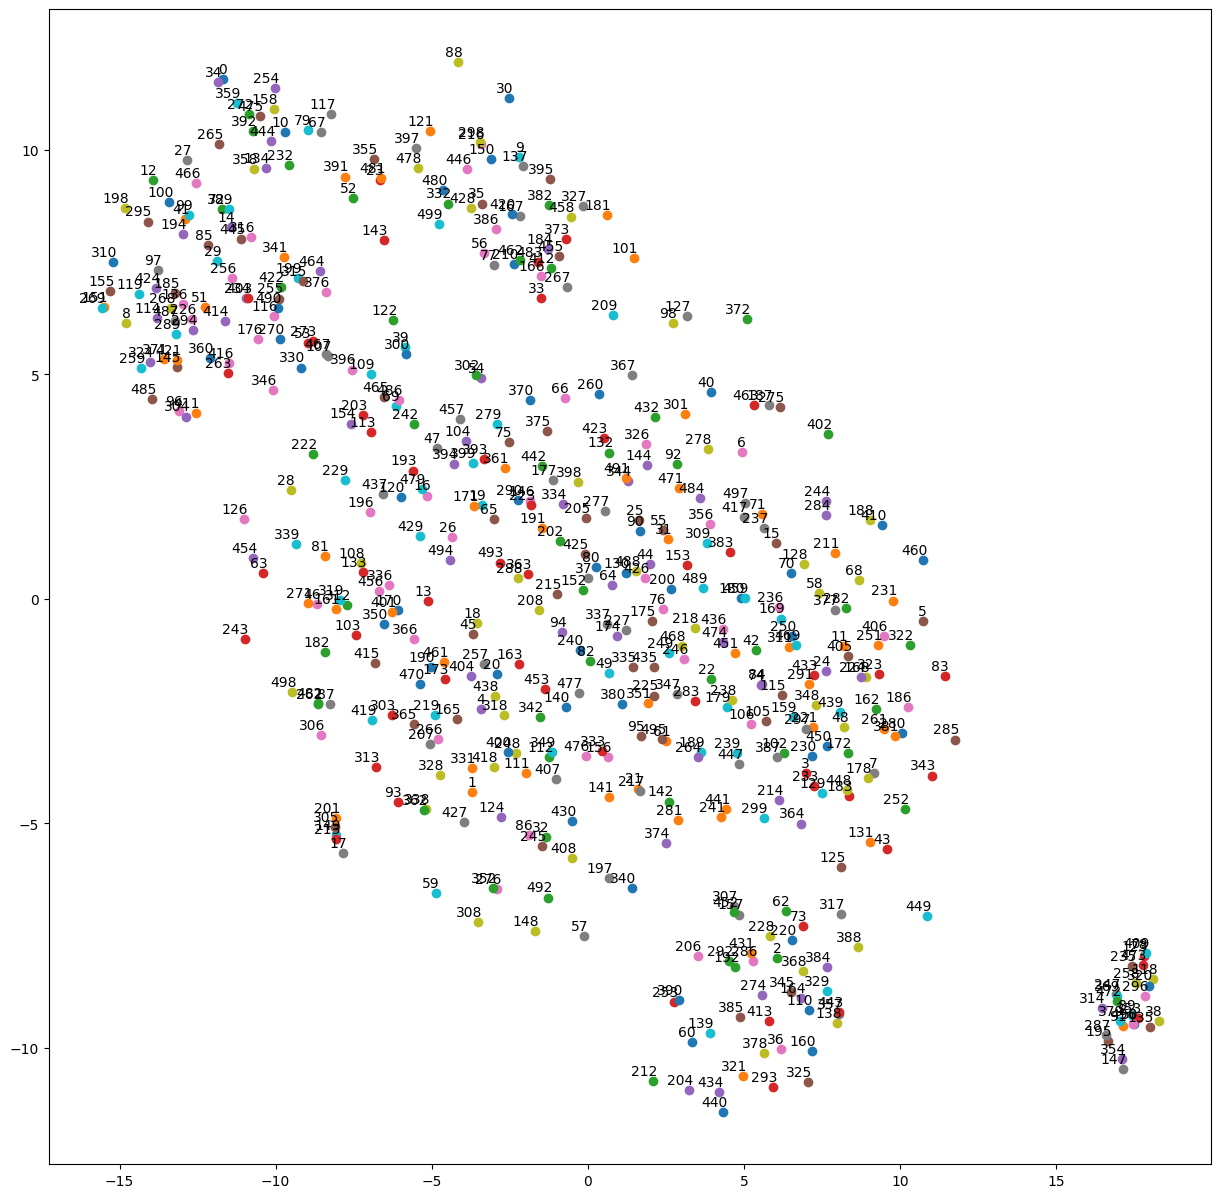

In [ ]:
pca_values = tsne_plot(user_embeddings, test_data['profile_uid'], 500)

In [ ]:
user_embeddings[0][:10]

array([-0.05497238,  0.14721707, -0.17721307, -0.00849655, -0.06847118,
       -0.02836373,  0.07166302,  0.01663499, -0.01384283, -0.04095878],
      dtype=float32)

In [ ]:
user_embeddings[1][:10]

array([-0.05497238,  0.14721714, -0.17721307, -0.00849656, -0.06847118,
       -0.02836371,  0.07166305,  0.01663496, -0.01384284, -0.04095877],
      dtype=float32)

In [ ]:
for i in range(10):
  print(f'User {i} Recommendations:')
  print(anime_recommendations(user_embeddings[i].reshape(1,-1)[0]))

User 0 Recommendations:
0                        Pokemon Advanced Generation
1                                        Dragon Half
2                                      Yuugen Kaisha
3                                         Himawari!!
4    Detective Conan OVA 01: Conan vs. Kid vs. Yaiba
5                                         Jyu Oh Sei
6                           Lupin III: Dead or Alive
7                                           Shuffle!
Name: title, dtype: object
User 1 Recommendations:
0                       Sakura Taisen: Gouka Kenran
1                           Pokemon Diamond & Pearl
2                             Shihaisha no Tasogare
3                                           Area 88
4                                     Abashiri Ikka
5                                     Ushio to Tora
6       Dragon Ball Z: Saiya-jin Zetsumetsu Keikaku
7    Top wo Nerae! & Top wo Nerae 2! Gattai Movie!!
8                                      Shuten Douji
Name: title, dtype: object
User 2

BERT embeddings are uniquely creating embeddings for users and animes

### Coverage

In [35]:
selected_test_data = test_data.iloc[:num_val_examples]
unique_profile_ids = selected_test_data['profile_uid'].unique()
print(len(unique_profile_ids))

948


In [36]:
unique_recommendations = set()
unique_recommendation_pairs = set()
total_recommendations = 0
user_recommendations = 0
for i in range(len(user_embeddings)):
  recommendations = anime_recommendations(user_embeddings[i])
  unique_recommendations.update(recommendations.values)
  unique_recommendation_pairs.update([(selected_test_data.iloc[i]['profile_uid'], rec) for rec in recommendations.values])
  total_recommendations += len(recommendations)
  if len(recommendations) > 0:
    user_recommendations += 1



print(f'Unique Recommendations: {len(unique_recommendations)}')
print(f'Unique Recommendation Pairs: {len(unique_recommendation_pairs)}')
print(f'Total Recommendations: {total_recommendations}')
print(f'User Recommendations: {user_recommendations}')

Unique Recommendations: 1547
Unique Recommendation Pairs: 9013
Total Recommendations: 9017
User Recommendations: 1000


In [37]:

print(f'Item Coverage: {len(unique_recommendations) / len(unique_anime_ids)}')
print(f'User Coverage: {user_recommendations / num_val_examples}')
print(f'Total Coverage: {len(unique_recommendation_pairs) / (len(unique_anime_ids) * len(unique_profile_ids))}')

Item Coverage: 0.7735
User Coverage: 1.0
Total Coverage: 0.004753691983122363


### Precision and Recall at K

In [38]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, true_r, est in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [39]:
selected_test_datat = test_data.iloc[:num_val_examples]

In [40]:
prediction_input_dataset = tf.data.Dataset.zip(((
    tf.data.Dataset.from_tensor_slices(bert_test_synopsis.input_ids),
    tf.data.Dataset.from_tensor_slices(bert_test_synopsis.token_type_ids),
    tf.data.Dataset.from_tensor_slices(bert_test_synopsis.attention_mask),
    tf.data.Dataset.from_tensor_slices(x_test.input_ids),
    tf.data.Dataset.from_tensor_slices(x_test.token_type_ids),
    tf.data.Dataset.from_tensor_slices(x_test.attention_mask),
),)).batch(len(x_test.attention_mask))

model_predictions = two_tower_bert_model.predict(prediction_input_dataset)

1/1 [==============================] - 11s 11s/step


In [41]:
k = 10
precisions, recalls = precision_recall_at_k(zip(selected_test_datat['profile_uid'], y_test, model_predictions), k=k, threshold=7)

precision_at_k = sum(prec for prec in precisions.values())[0][0] / len(precisions)
recall_at_k = sum(rec for rec in recalls.values())[0][0] / len(recalls)

print(f'Precision@{k}: {precision_at_k}')
print(f'Recall@{k}: {recall_at_k}')
print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')

Precision@10: 0.6925105485232067
Recall@10: 0.7014767932489452
F1@10: 0.6969648350630836


In [42]:
k = 10
precisions, recalls = precision_recall_at_k(zip(selected_test_datat['profile_uid'], y_test, model_predictions), k=k, threshold=7.5)


precision_at_k = sum(prec for prec in precisions.values())[0][0] / len(precisions)
recall_at_k = sum(rec for rec in recalls.values())[0][0] / len(recalls)

print(f'Precision@{k}: {precision_at_k}')
print(f'Recall@{k}: {recall_at_k}')
print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')

Precision@10: 0.5469409282700421
Recall@10: 0.5548523206751055
F1@10: 0.5508682207181277
